In [159]:
import torch
import torch_geometric as pyg
import numpy as np
import  cgvae.data_transform
import importlib
importlib.reload(cgvae.data_transform)
from cgvae.data_transform import get_data
import cgvae.baseline
importlib.reload(cgvae.baseline)
import cgvae.cgvae_model
importlib.reload(cgvae.cgvae_model)

import  cgvae
importlib.reload(cgvae)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

torch.manual_seed(123)
np.random.seed(123)

<module 'cgvae.data_transform' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/cgvae/data_transform.py'>

<module 'cgvae.baseline' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/cgvae/baseline.py'>

<module 'cgvae.cgvae_model' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/cgvae/cgvae_model.py'>

<module 'cgvae' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/cgvae/__init__.py'>

In [160]:
%cd /Users/cgu3/Documents/cgvae
%pwd

/Users/cgu3/Documents/cgvae


'/Users/cgu3/Documents/cgvae'

In [161]:
SPLIT_RATIO = 0.1
dataloader, dataset_size = cgvae.data_transform.get_data('../data', 'Cora', mask_ratio=SPLIT_RATIO, num_val=0.1, num_test=0.1)
# dataloader, dataset_size = get_data('../data', 'KarateClub',  mask_ratio=SPLIT_RATIO, num_val=0.1, num_test=0.1, neg_edge_ratio=3)

In [162]:
data = next(iter(dataloader))
dim = data['input'].x.shape[0]

In [163]:
baseline_net = cgvae.baseline.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=100,
    model_path='checkpoints/baseline_net.pth',
    early_stop_patience=100
)

NN Epoch 99         : 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, early_stop_count=69, loss=0.3769, phase=val]


In [164]:
cgvae_net = cgvae.cgvae_model.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=100,
    pre_trained_baseline_net=baseline_net,
    model_path='checkpoints/cgvae_net.pth',
    early_stop_patience=100,
    regularization=0.2
)

CVAE Epoch 99       : 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, early_stop_count=93, loss=0.4506, phase=val]


In [165]:
# generate missing part based on the trained model

In [166]:
# sample one data from the dataloader
graphs = next(iter(dataloader))
graphs

{'input': DataBatch(x=[2708, 1433], edge_index=[2, 10428], edge_weight=[10428], batch=[2708], ptr=[2]),
 'output': DataBatch(x=[2708, 1433], edge_index=[2, 256], edge_label=[256], train_mask=[256], val_mask=[256], test_mask=[256], batch=[2708], ptr=[2])}

In [167]:
graphs['output'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Visualize the input graph

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

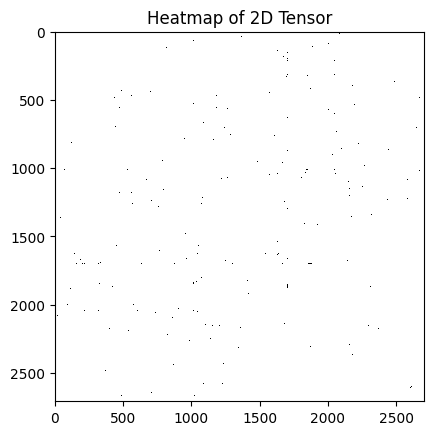

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

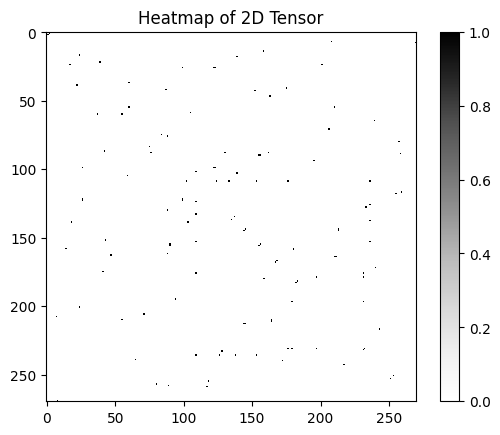

In [168]:
import matplotlib.pyplot as plt
split = int(dim * SPLIT_RATIO)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
# Plot the heatmap
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
plt.title("Heatmap of 2D Tensor")
plt.show()
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title("Heatmap of 2D Tensor")
plt.show()

In [169]:
# Convert the tensor to a NumPy array
# Plot the heatmap


In [170]:
# use the trained model to generate the missing part
baseline_net(graphs['input'])

tensor([[ 0.7318, -2.0749, -1.0091,  ...,  0.2902,  0.4190,  0.4332],
        [-2.0749, 10.4433,  5.3443,  ..., -0.6912, -1.2854, -1.2372],
        [-1.0091,  5.3443,  2.8487,  ..., -0.1850, -0.6130, -0.5992],
        ...,
        [ 0.2902, -0.6912, -0.1850,  ...,  0.4983,  0.2265,  0.2064],
        [ 0.4190, -1.2854, -0.6130,  ...,  0.2265,  0.2932,  0.2943],
        [ 0.4332, -1.2372, -0.5992,  ...,  0.2064,  0.2943,  0.3110]],
       grad_fn=<MmBackward0>)

In [171]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<Axes: >

Text(0.5, 1.0, 'Input')

<Axes: >

Text(0.5, 1.0, 'Output')

<Axes: >

Text(0.5, 1.0, 'Baseline model')

<Axes: >

Text(0.5, 1.0, 'Recognition model')

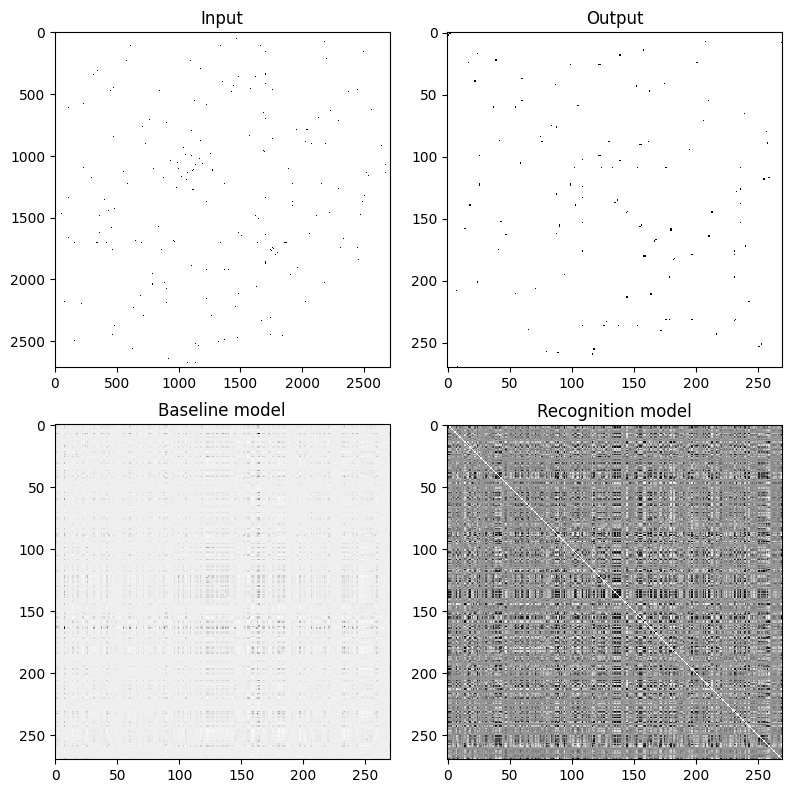

In [172]:
dim = graphs['input'].x.size(0)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
threshold = 0.8


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplot(221)
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Input")

plt.subplot(222)
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Output")

plt.subplot(223)
adj_mat_np = baseline_net(graphs['input']).detach().numpy()[:split, :split]
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np = np.random.binomial(1, adj_mat_np)
np.fill_diagonal(adj_mat_np, 0)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Baseline model")

plt.subplot(224)
adj_mat_np = np.zeros((split, split))
for i in range(100):
    adj_mat_np += sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
adj_mat_np /= 100
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np[adj_mat_np >= threshold] = 1
np.fill_diagonal(adj_mat_np, 0)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Recognition model")

# also try unconditional generation


plt.show()



Text(0.5, 1.0, 'Output')

Text(0.5, 1.0, 'Recognition model generated graph 3')

Text(0.5, 1.0, 'Recognition model generated graph 4')

Text(0.5, 1.0, 'Recognition model generated graph 5')

Text(0.5, 1.0, 'Recognition model generated graph 6')

Text(0.5, 1.0, 'Recognition model generated graph 7')

Text(0.5, 1.0, 'Recognition model generated graph 8')

Text(0.5, 1.0, 'Recognition model generated graph 9')

Text(0.5, 1.0, 'Recognition model generated graph 10')

Text(0.5, 1.0, 'Recognition model generated graph 11')

Text(0.5, 1.0, 'Recognition model generated graph 12')

Text(0.5, 1.0, 'Recognition model generated graph 13')

Text(0.5, 1.0, 'Recognition model generated graph 14')

Text(0.5, 1.0, 'Recognition model generated graph 15')

Text(0.5, 1.0, 'Recognition model generated graph 16')

Text(0.5, 1.0, 'Recognition model generated graph (average)')

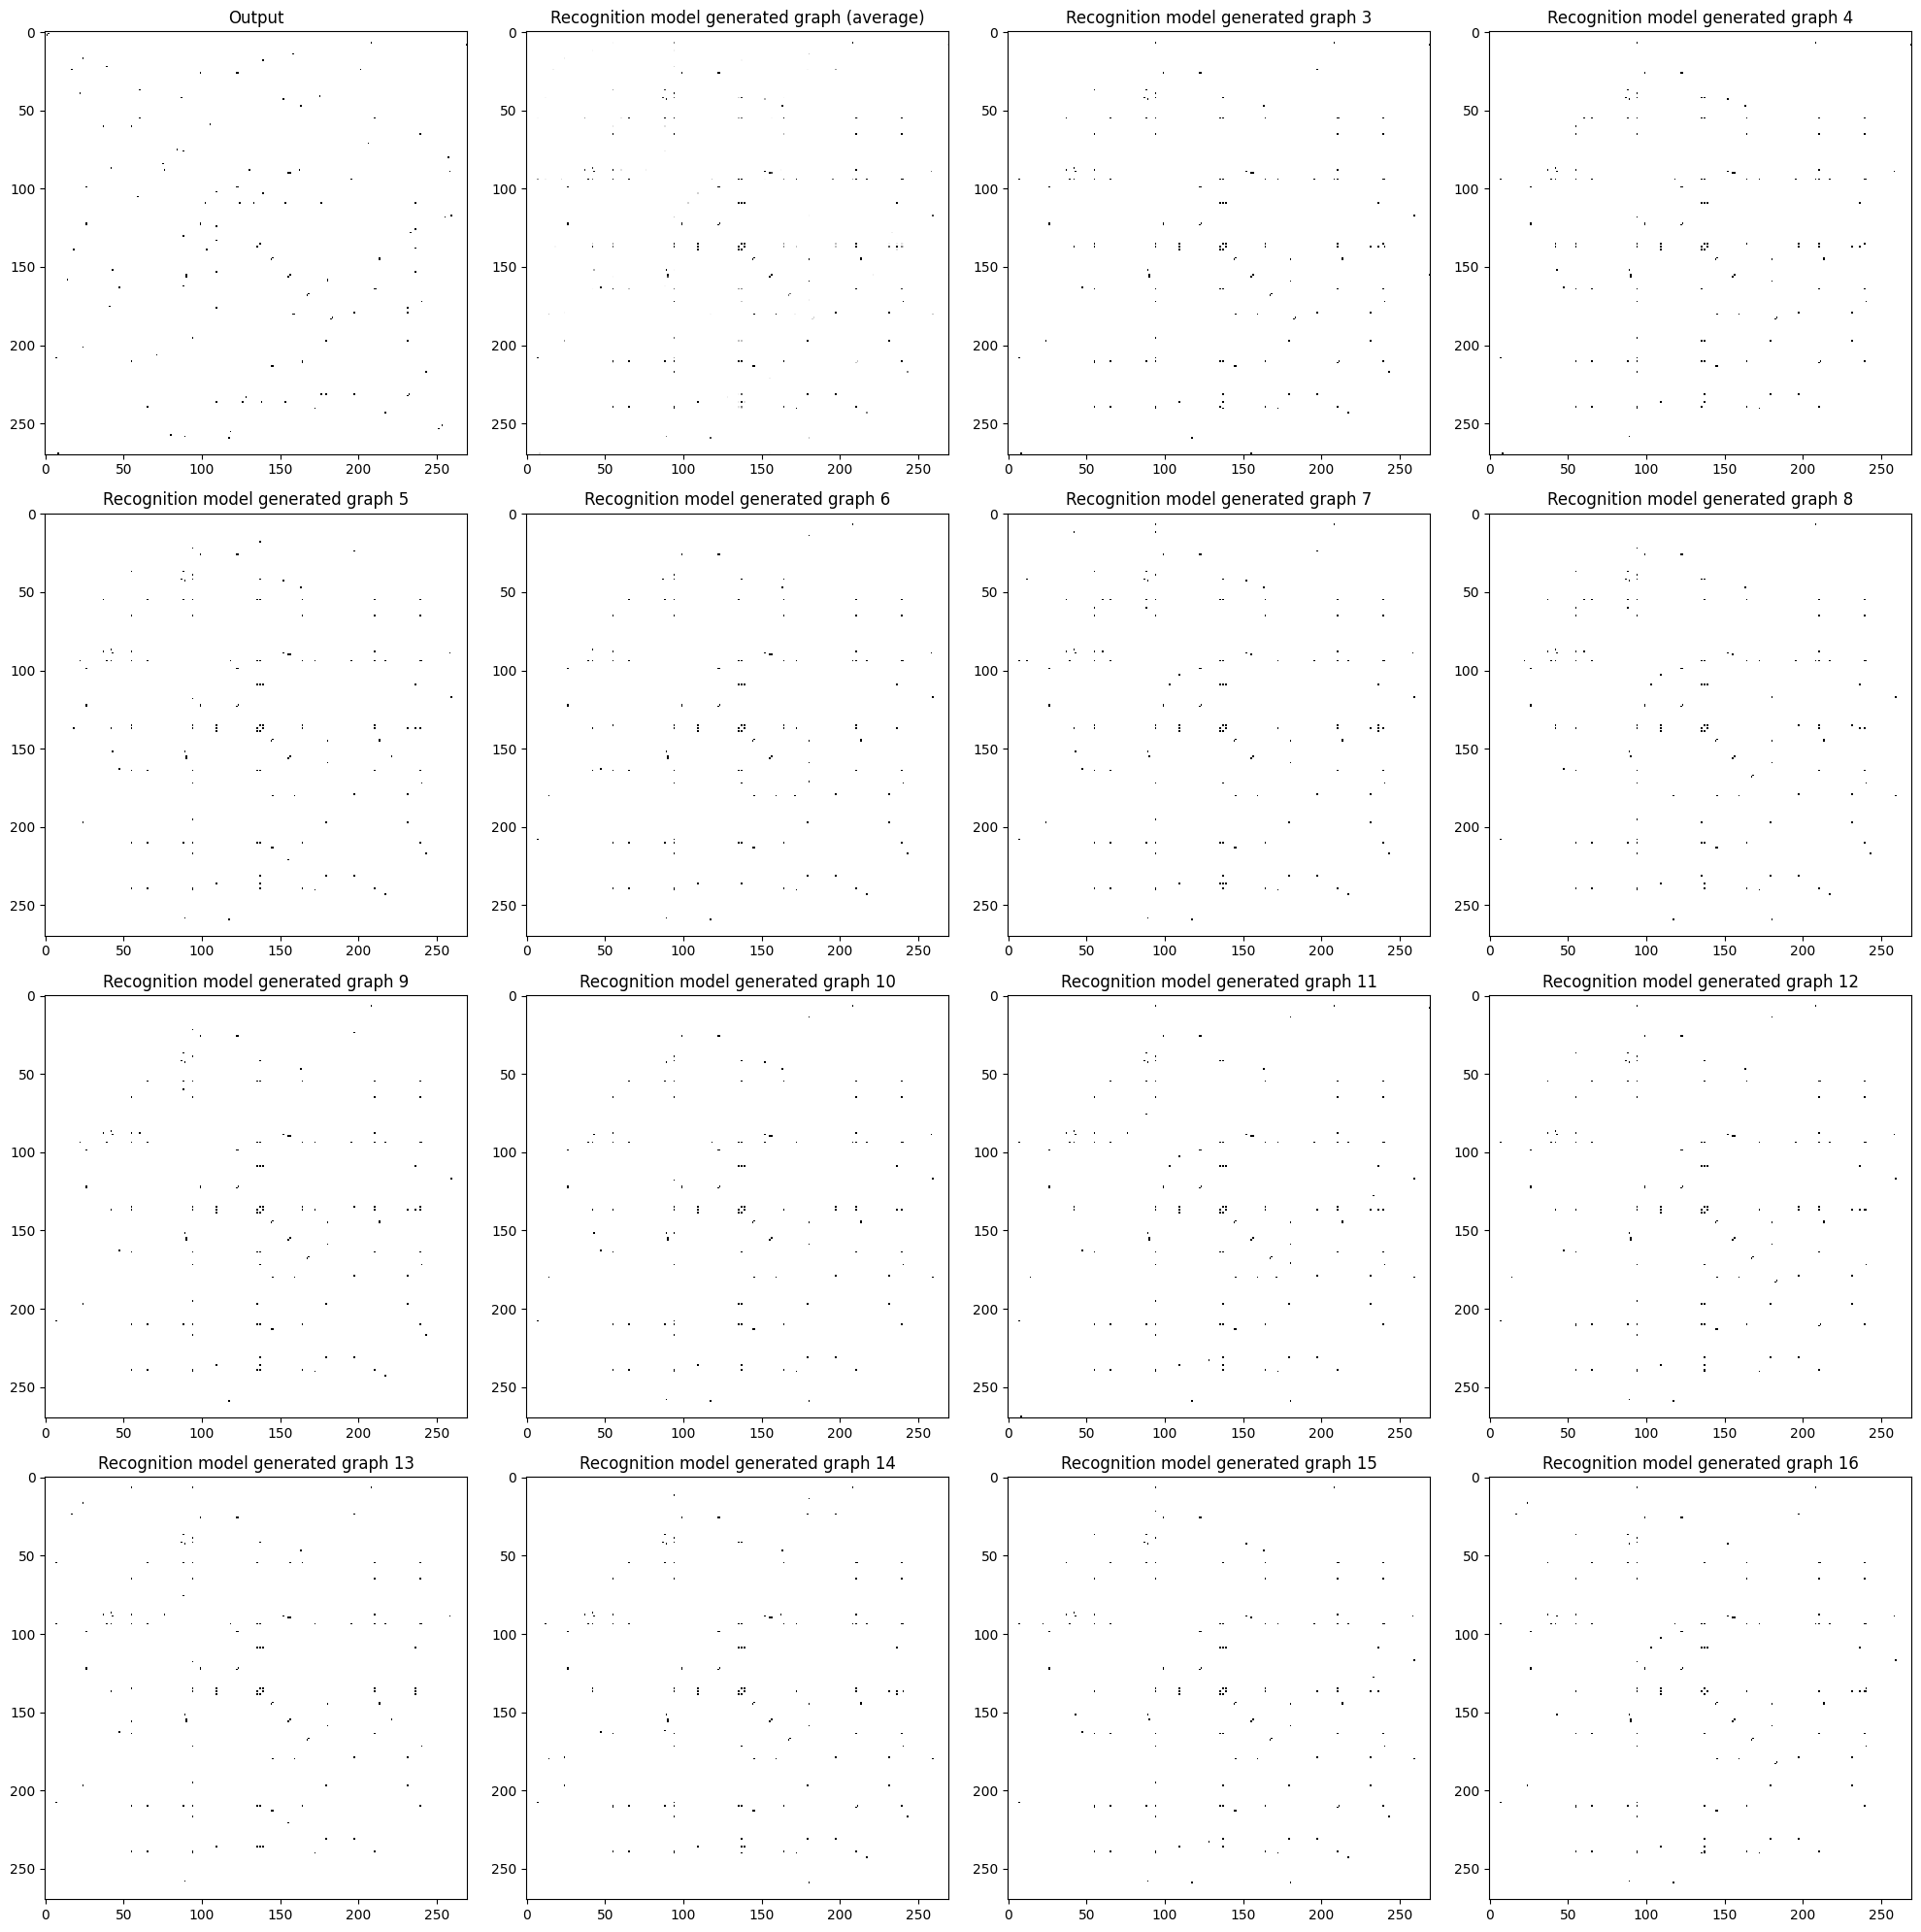

In [187]:
cgvae_net.load('checkpoints/cgvae_net.pth')
threshold = 0.99

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))

for i in range(2, 16):
    adj_mat_np = sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    ax.set_title(f"Recognition model generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14
ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

In [174]:
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from datetime import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import VGAE
# Unconditional generation
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class VGAEWithGenerate(VGAE):
    def __init__(self, encoder):
        super().__init__(encoder)
        self.encoder = encoder
        
    def generate(self):
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return self.decoder.forward_all(z)

vgae_model = VGAEWithGenerate(VariationalGCNEncoder(1433, 50))
model = vgae_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


train_data = Planetoid(root='../data', name='Cora', pre_transform=ToUndirected())[0]
train_data.pos_edge_label_index = train_data.edge_index
train_data.neg_edge_label_index = pyg.utils.negative_sampling(
    train_data.edge_index, num_nodes=train_data.num_nodes)

# train the model
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

times = []
for epoch in range(1, 100 + 1):
    # start = time.time()
    loss = train()
    # auc, ap = test(test_data)
    # print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    # times.append(time.time() - start)
# print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

In [156]:
split

270

Text(0.5, 1.0, 'Output')

Text(0.5, 1.0, 'Unconditional VAE generated graph 3')

Text(0.5, 1.0, 'Unconditional VAE generated graph 4')

Text(0.5, 1.0, 'Unconditional VAE generated graph 5')

Text(0.5, 1.0, 'Unconditional VAE generated graph 6')

Text(0.5, 1.0, 'Unconditional VAE generated graph 7')

Text(0.5, 1.0, 'Unconditional VAE generated graph 8')

Text(0.5, 1.0, 'Unconditional VAE generated graph 9')

Text(0.5, 1.0, 'Unconditional VAE generated graph 10')

Text(0.5, 1.0, 'Unconditional VAE generated graph 11')

Text(0.5, 1.0, 'Unconditional VAE generated graph 12')

Text(0.5, 1.0, 'Unconditional VAE generated graph 13')

Text(0.5, 1.0, 'Unconditional VAE generated graph 14')

Text(0.5, 1.0, 'Unconditional VAE generated graph 15')

Text(0.5, 1.0, 'Unconditional VAE generated graph 16')

Text(0.5, 1.0, 'Recognition model generated graph (average)')

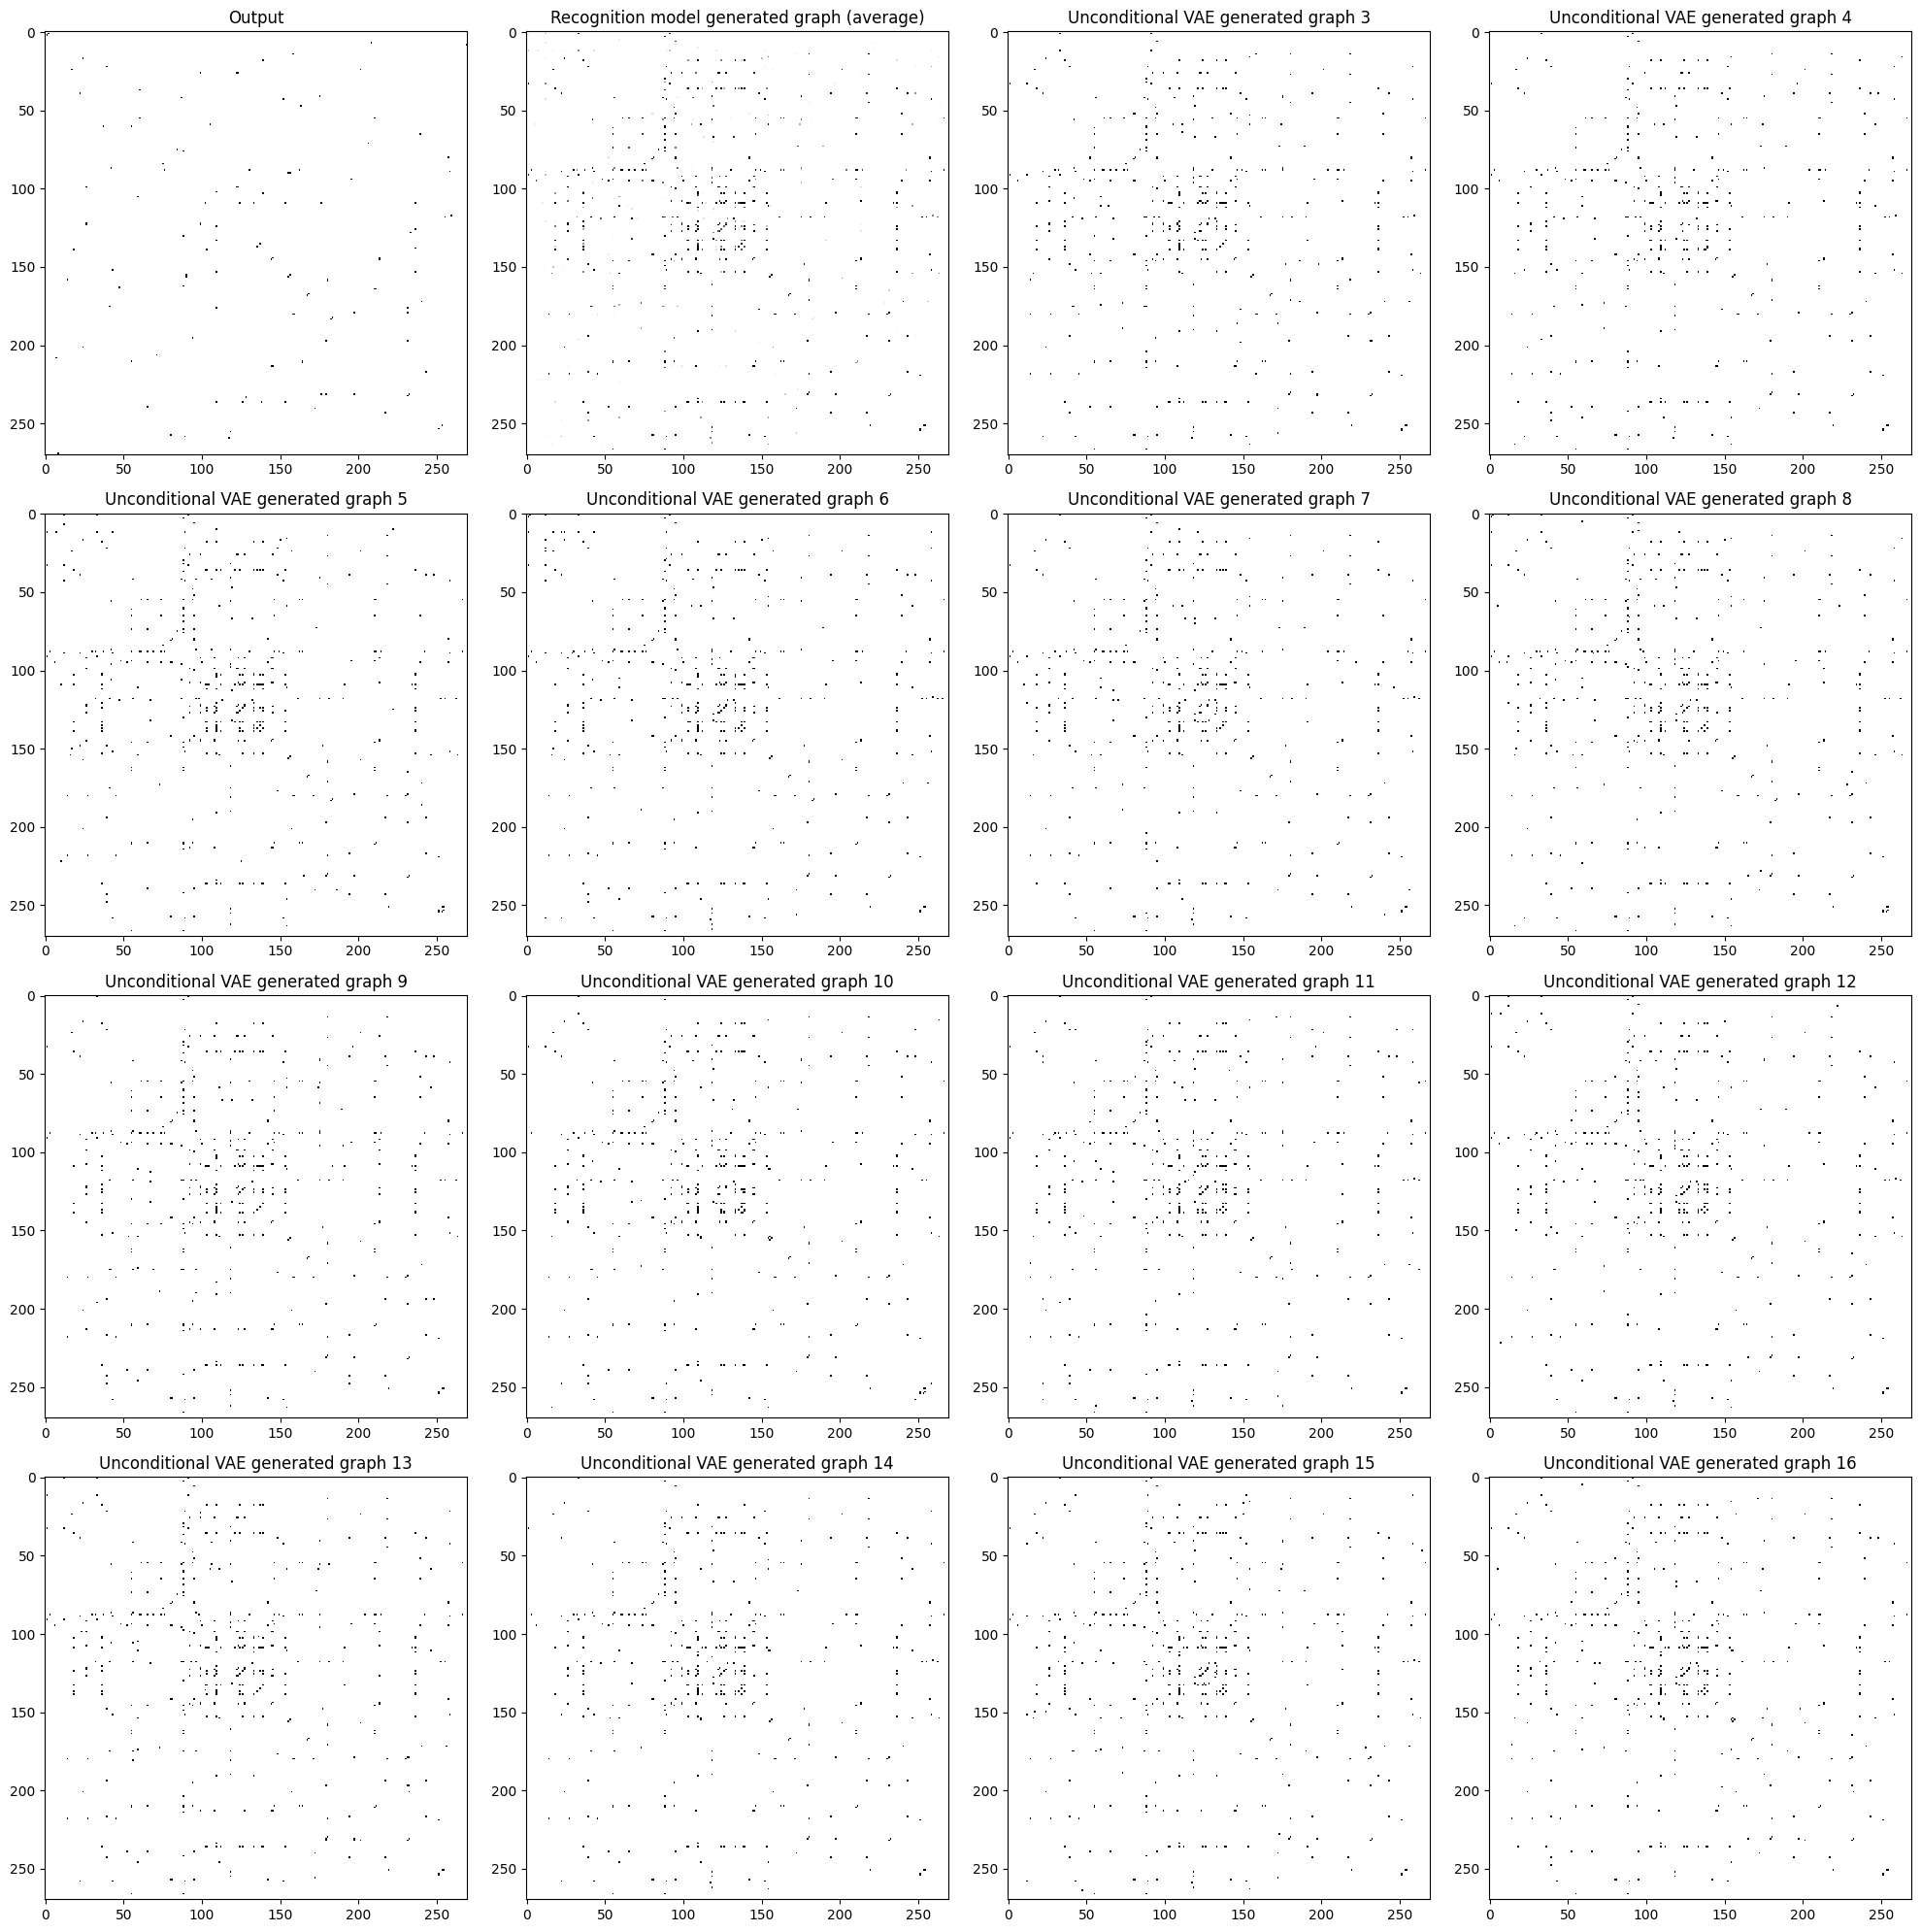

In [185]:
threshold = 0.95

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))
for i in range(2, 16):
    adj_mat_np = vgae_model.generate().detach().numpy()[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    ax.set_title(f"Unconditional VAE generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14
ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")


plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

# Experiment 

Let's random remove some edges from the input graph and see how well the models can recover the missing edges.

In [1]:
graphs

NameError: name 'graphs' is not defined